In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys
from pathlib import Path
import datetime as dt
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import json


In [3]:
def load_ior_summary_list(json_file: Path):
    try:
        data = json.loads(json_file.read_text())
        return [
            {
                'Version': data['Version'],
                'Began': data['Began'],
                'Command line': data['Command line'],
                'Machine': data['Machine'],
                'Finished': data['Finished'],
                **{f'test_{k}': v for k, v in test.items() if k not in ["Results", "max", "Parameters", "Options"]},
                **{f"max_{k}": v for k, v in test["max"].items()},
                **{f"Parameters_{k}": v for k, v in test["Parameters"].items()},
                **{f"Options_{k}": v for k, v in test["Options"].items()},
                **{f'summary_{k}': v for k, v in data['summary'][index].items()},
                **{f'result_{k}': v for k, v in result.items()},
                'iorIteration': iteration,
            }
            for index, test in enumerate(data['tests'])
            for iteration, results in enumerate(test["Results"]) # iteration ?
            for result in results
        ]
    except Exception as e:
        print(f"Error processing file {json_file}: {e}")
        return []


In [4]:
IOR_OUTPUT_DIR = Path("../raw/ior")

df_src = pl.DataFrame([
    log
    for log_dir in IOR_OUTPUT_DIR.glob("*")
    for json in log_dir.glob("ior_summary_*.json")
    for log in load_ior_summary_list(json)
])

df_src.head(5)

Version,Began,Command line,Machine,Finished,test_TestID,test_StartTime,test_Path,test_Capacity,test_Used Capacity,test_Inodes,test_Used Inodes,max_readMiB,max_readMB,Parameters_testID,Parameters_refnum,Parameters_api,Parameters_platform,Parameters_testFileName,Parameters_hintsFileName,Parameters_deadlineForStonewall,Parameters_stoneWallingWearOut,Parameters_maxTimeDuration,Parameters_outlierThreshold,Parameters_options,Parameters_dryRun,Parameters_nodes,Parameters_memoryPerTask,Parameters_memoryPerNode,Parameters_tasksPerNode,Parameters_repetitions,Parameters_multiFile,Parameters_interTestDelay,Parameters_fsync,Parameters_fsyncperwrite,Parameters_useExistingTestFile,Parameters_showHints,…,summary_TestID,summary_ReferenceNumber,summary_segmentCount,summary_blockSize,summary_transferSize,summary_numTasks,summary_tasksPerNode,summary_repetitions,summary_filePerProc,summary_reorderTasks,summary_taskPerNodeOffset,summary_reorderTasksRandom,summary_reorderTasksRandomSeed,summary_bwMaxMIB,summary_bwMinMIB,summary_bwMeanMIB,summary_bwStdMIB,summary_OPsMax,summary_OPsMin,summary_OPsMean,summary_OPsSD,summary_MeanTime,summary_xsizeMiB,result_access,result_bwMiB,result_blockKiB,result_xferKiB,result_iops,result_latency,result_openTime,result_wrRdTime,result_closeTime,result_totalTime,iorIteration,Options_task offset,max_writeMiB,max_writeMB
str,str,str,str,str,i64,str,str,str,str,str,str,f64,f64,i64,i64,str,str,str,str,i64,i64,i64,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,f64,f64
"""3.3.0""","""Thu May 16 12:54:32 2024""","""ior -a MPIIO -l timestamp -g -…","""Linux chris90""","""Thu May 16 12:54:41 2024""",0,"""Thu May 16 12:54:32 2024""","""/shared/fish/hiraga/work/peanu…","""54.6 TiB""","""34.8%""","""1117.6 Mi""","""3.4%""",37143.8696,38948.1702,0,0,"""MPIIO""","""chris(Linux)""","""/shared/fish/hiraga/work/peanu…","""(null)""",0,0,0,0,"""(null)""",0,1,0,0,16,1,0,0,1,0,0,0,…,0,0,1,21474836480,32768,16,16,1,0,0,1,0,0,37143.8696,37143.8696,37143.8696,0.0,1.1886e6,1.1886e6,1.1886e6,0.0,8.8219,327680.0,"""read""",37143.8696,2.097152e7,32.0,1.1887e6,0.0,0.0006,8.8212,0.0001,8.8219,0,null,null,null
"""3.3.0""","""Thu May 16 13:13:36 2024""","""ior -a MPIIO -l timestamp -g -…","""Linux chris90""","""Thu May 16 13:13:49 2024""",0,"""Thu May 16 13:13:36 2024""","""/shared/fish/hiraga/work/peanu…","""54.6 TiB""","""34.8%""","""1117.6 Mi""","""3.4%""",24527.4205,25718.8645,0,0,"""MPIIO""","""chris(Linux)""","""/shared/fish/hiraga/work/peanu…","""(null)""",0,0,0,0,"""(null)""",0,1,0,0,16,1,0,0,1,0,0,0,…,0,0,1,21474836480,512,16,16,1,0,0,1,0,0,24527.4205,24527.4205,24527.4205,0.0,5.0232e7,5.0232e7,5.0232e7,0.0,13.3597,327680.0,"""read""",24527.4205,2.097152e7,0.5,5.0234e7,0.0,0.0005,13.3591,0.0001,13.3597,0,null,null,null
"""3.3.0""","""Thu May 16 12:42:06 2024""","""ior -a MPIIO -l timestamp -g -…","""Linux chris90""","""Thu May 16 12:42:13 2024""",0,"""Thu May 16 12:42:06 2024""","""/shared/fish/hiraga/work/peanu…","""54.6 TiB""","""34.8%""","""1117.6 Mi""","""3.4%""",41944.3234,43981.8108,0,0,"""MPIIO""","""chris(Linux)""","""/shared/fish/hiraga/work/peanu…","""(null)""",0,0,0,0,"""(null)""",0,1,0,0,16,1,0,0,1,0,0,0,…,0,0,1,21474836480,262144,16,16,1,0,0,1,0,0,41944.3234,41944.3234,41944.3234,0.0,167777.2935,167777.2935,167777.2935,0.0,7.8123,327680.0,"""read""",41944.3234,2.097152e7,256.0,167793.0427,0.0001,0.0006,7.8115,0.0001,7.8123,0,null,null,null
"""3.3.0""","""Thu May 16 13:06:27 2024""","""ior -a MPIIO -l timestamp -g -…","""Linux chris90""","""Thu May 16 13:06:40 2024""",0,"""Thu May 16 13:06:27 2024""","""/shared/fish/hiraga/work/peanu…","""54.6 TiB""","""34.8%""","""1117.6 Mi""","""3.4%""",24882.5183,26091.2115,0,0,"""MPIIO""","""chris(Linux)""","""/shared/fish/hiraga/work/peanu…","""(null)""",0,0,0,0,"""(null)""",0,1,0,0,16,1,0,0,1,0,0,0,…,0,0,1,21474836480,2048,16,16,1,0,1,1,0,

In [5]:
# constants from https://github.com/range3/pmembench/blob/4db7408da4a5a5767c93657cc03cd933f3fac61c/eval/plot/pmem2bench.ipynb
PMEM_READ_LIMIT_PER_NODE = 46.949817 * 2**30 / 10**9
PMEM_WRITE_LIMIT_PER_NODE = 14.658652 * 2**30 / 10**9
NETWORK_LIMIT_PER_NODE = 100 / 8

print(f"PMEM_READ_LIMIT_PER_NODE: {PMEM_READ_LIMIT_PER_NODE} GB/s")
print(f"PMEM_WRITE_LIMIT_PER_NODE: {PMEM_WRITE_LIMIT_PER_NODE} GB/s")
print(f"NETWORK_LIMIT_PER_NODE: {NETWORK_LIMIT_PER_NODE} GB/s")

def network_limit(nnodes):
    return nnodes * NETWORK_LIMIT_PER_NODE

def pmem_read_limit(nnodes):
    return nnodes * PMEM_READ_LIMIT_PER_NODE

def pmem_write_limit(nnodes):
    return nnodes * PMEM_WRITE_LIMIT_PER_NODE


PMEM_READ_LIMIT_PER_NODE: 50.41198214204621 GB/s
PMEM_WRITE_LIMIT_PER_NODE: 15.739607735861249 GB/s
NETWORK_LIMIT_PER_NODE: 12.5 GB/s


Access: write, Remote: False


,256,512,1024,2048,4096,8192,16384,32768,47008,65536,131072,262144,524288,1048576,2097152
Options_nodes,,,,,,,,,,,,,,,
1,15.753237,15.123443,14.464369,12.480895,9.578233,9.232038,9.136486,10.041835,11.822056,10.468301,10.780916,10.519376,10.282472,11.641063,12.249290
2,31.654211,30.197042,29.023495,24.981996,19.109914,18.429686,18.225689,19.964686,23.498496,20.829690,21.483604,20.794579,20.131333,20.436547,24.181861


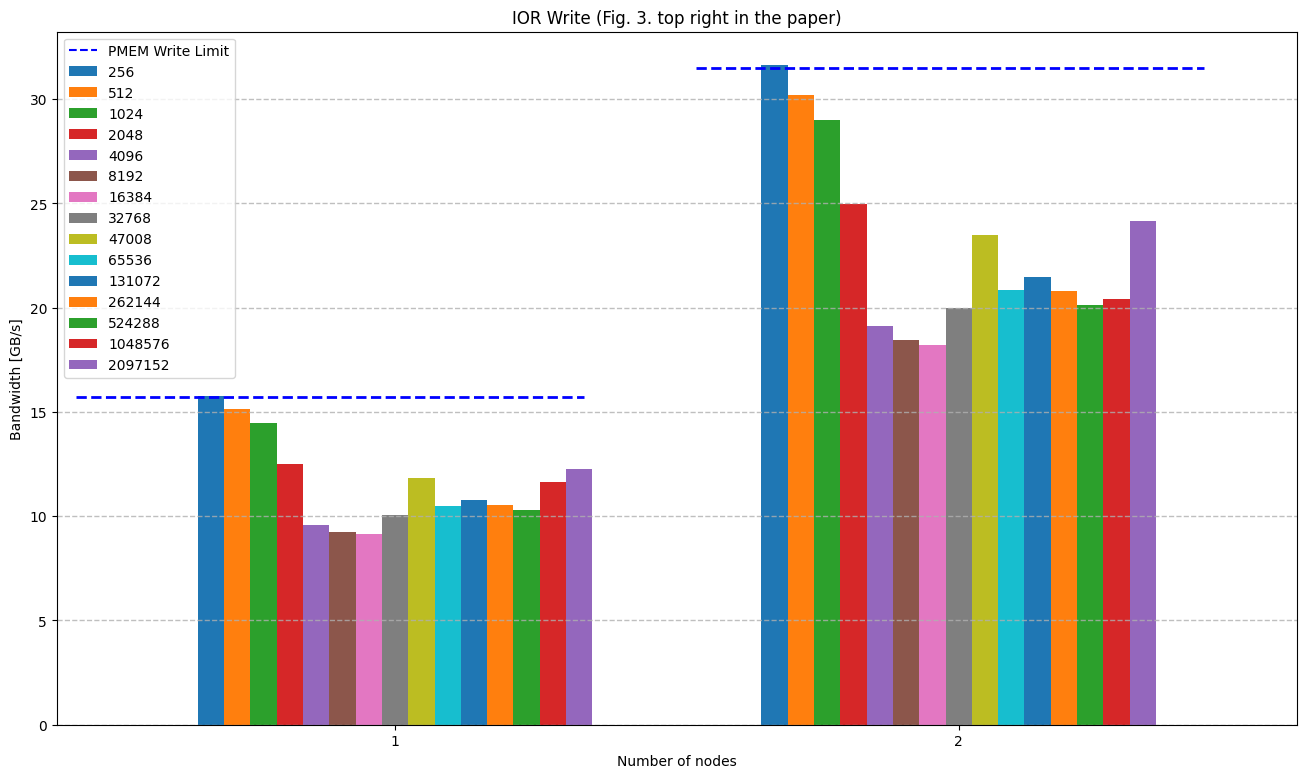

Access: read, Remote: True


,256,512,1024,2048,4096,8192,16384,32768,47008,65536,131072,262144,524288,1048576,2097152
Options_nodes,,,,,,,,,,,,,,,
2,3.035305,5.806098,10.159206,15.083636,22.34579,23.753487,23.940732,23.785585,23.876471,24.039907,24.028812,24.034355,24.036785,24.01146,23.653967


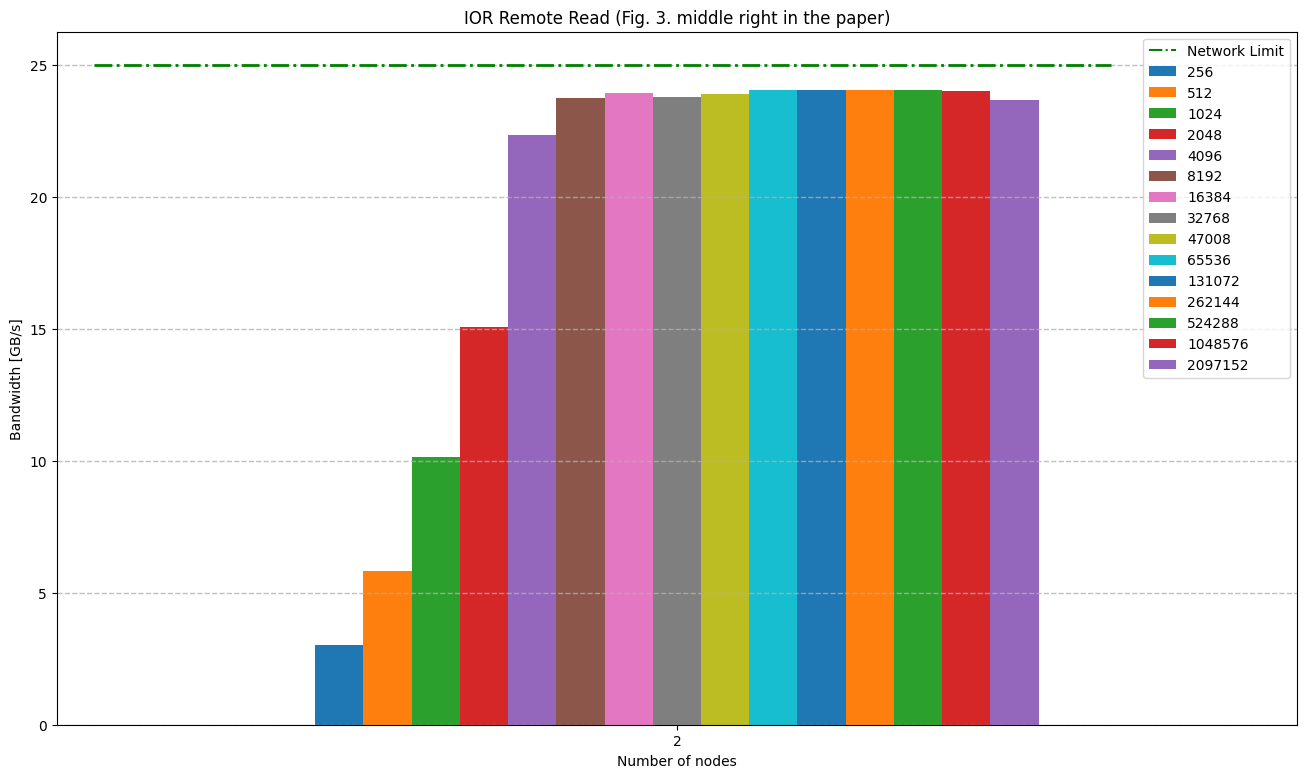

Access: read, Remote: False


,256,512,1024,2048,4096,8192,16384,32768,47008,65536,131072,262144,524288,1048576,2097152
Options_nodes,,,,,,,,,,,,,,,
1,25.131820,25.718864,25.808788,26.020558,20.704160,34.968679,31.977105,38.948170,42.888001,41.148484,42.722327,43.981811,44.472781,44.167613,34.374608
2,52.813083,50.701686,51.596417,51.898668,41.420405,69.813164,63.839332,77.603716,84.763041,81.072235,84.559648,86.561392,87.023017,86.261201,68.785758


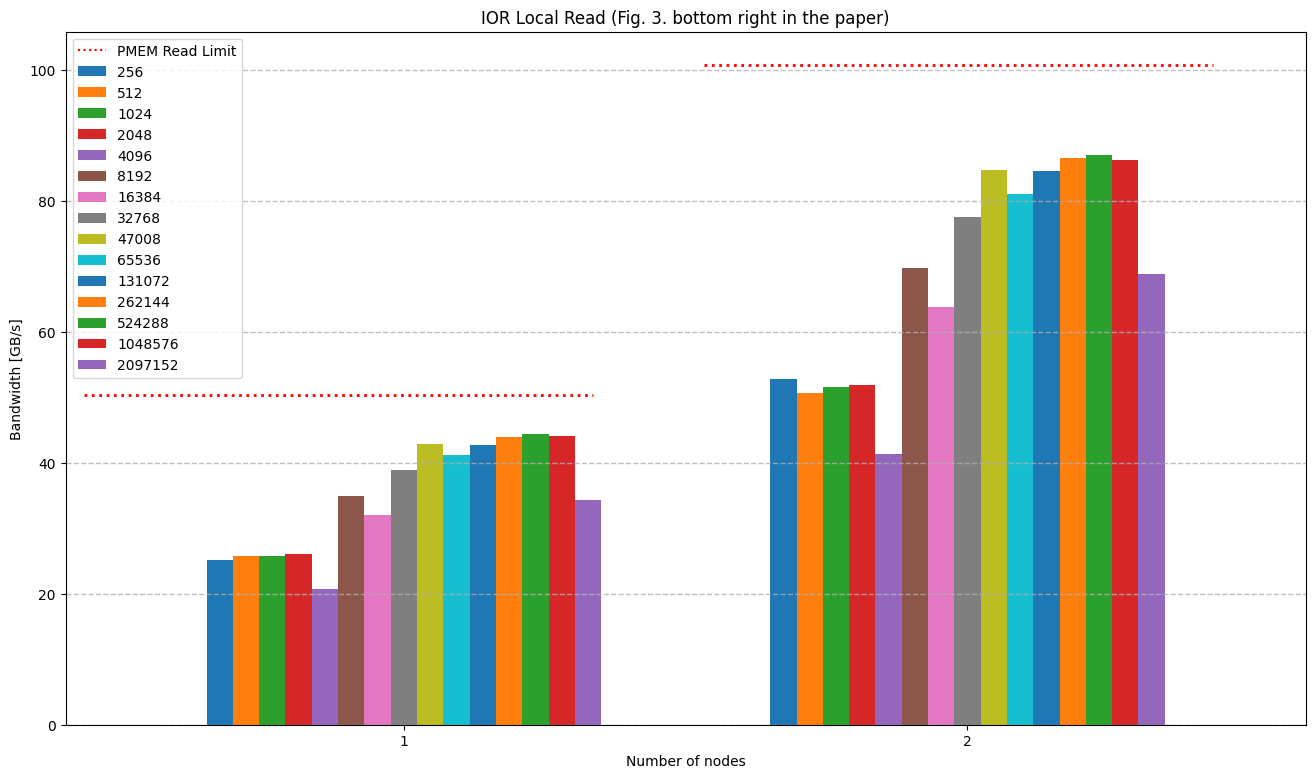

In [6]:
df = df_src

groupby_columns=[
    "Options_nodes",
    "summary_numTasks",
    "summary_reorderTasks",
    "summary_transferSize",
    "result_access",
]

df = (
    df
    .with_columns(
        pl.col("summary_reorderTasks").cast(pl.Boolean),
    )
    .group_by(groupby_columns)
    .agg([
        (pl.mean("result_bwMiB") * 2**20 / 10**9).alias("bwGB"),
    ])
)

for access, remote in [("write", False), ("read", True), ("read", False)]:
    print(f"Access: {access}, Remote: {remote}")
    fig = plt.figure(figsize=(16, 9), dpi=100)
    fig.patch.set_alpha(1)
    df_plot = (
        df
        .filter((pl.col("result_access") == access) & (pl.col("summary_reorderTasks") == remote))
        .sort(["Options_nodes", "summary_transferSize"])
        .pipe(lambda df: df.filter(pl.col("Options_nodes") >= 2) if access == "read" and remote else df)
        .pivot(values="bwGB", index="Options_nodes", columns="summary_transferSize")
        .to_pandas()
        .set_index("Options_nodes")
    )
    display(df_plot)
    ax = df_plot.plot(
        ax=fig.add_subplot(),
        kind="bar",
        xlabel="Number of nodes",
        ylabel="Bandwidth [GB/s]",
        rot=0,
        width=0.7,
    )
    title = ""
    if access == "write":
        title = "Write (Fig. 3. top right in the paper)"
    elif remote:
        title = "Remote Read (Fig. 3. middle right in the paper)"
    else:
        title ="Local Read (Fig. 3. bottom right in the paper)"
    ax.grid(which = "major", axis = "y", alpha = 0.8, linestyle = "--", linewidth = 1)
    ax.set_title(f"IOR {title}")

    # plot limits
    network_limits = [network_limit(nnodes) for nnodes in df_plot.index]
    pmem_read_limits = [pmem_read_limit(nnodes) for nnodes in df_plot.index]
    pmem_write_limits = [pmem_write_limit(nnodes) for nnodes in df_plot.index]
    xticks = ax.get_xticks()
    if access == 'write':
        for xtick, limit in zip(xticks, pmem_write_limits):
            ax.axhline(y=limit, xmin=(xtick+0.03)/len(xticks), xmax=(xtick + 0.85)/len(xticks), color='blue', linestyle='--', linewidth=2)
        ax.plot([], [], linestyle="--", color="blue", label="PMEM Write Limit")
    elif remote == False:
        for xtick, limit in zip(xticks, pmem_read_limits):
            ax.axhline(y=limit, xmin=(xtick+0.03)/len(xticks), xmax=(xtick + 0.85)/len(xticks), color='red', linestyle=':', linewidth=2)
        ax.plot([], [], linestyle=":", color="red", label="PMEM Read Limit")
    else:
        for xtick, limit in zip(xticks, network_limits):
            ax.axhline(y=limit, xmin=(xtick+0.03)/len(xticks), xmax=(xtick + 0.85)/len(xticks), color='green', linestyle='-.', linewidth=2)
        ax.plot([], [], linestyle="-.", color="green", label="Network Limit")
    ax.legend(title="")

    plt.show()
